# Run Experiments

In [1]:
# Connect to your workspace

import azureml.core
from azureml.core import Workspace

# Load the workspace from the saved config file
ws = Workspace.from_config()
print('Ready to use Azure ML {} to work with {}'.format(azureml.core.VERSION, ws.name))

Ready to use Azure ML 1.21.0 to work with mymachinelearningws


In [2]:
# Run an experiment

from azureml.core import Experiment
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# Create an Azure ML experiment in your workspace

experiment = Experiment(workspace=ws, name="diabetes-experiment")

In [4]:
# Start logging data from the experiment, obtaining a reference to the experiment run

run = experiment.start_logging()
print("Starting experiment:", experiment.name)

Starting experiment: diabetes-experiment


In [5]:
# load the data from a local file

data = pd.read_csv('data/diabetes.csv')

In [6]:
# Count the rows and log the result

row_count = (len(data))
run.log('observations', row_count)
print('Analyzing {} rows of data'.format(row_count))

Analyzing 10000 rows of data


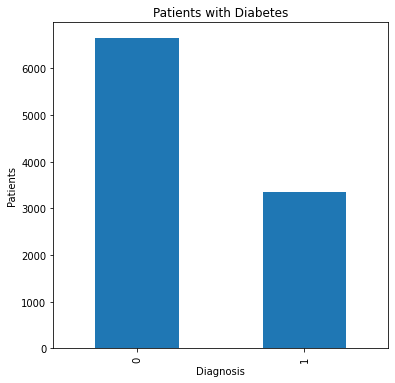

In [7]:
# Plot and log the count of diabetic vs non-diabetic patients

diabetic_counts = data['Diabetic'].value_counts()
fig = plt.figure(figsize=(6,6))
ax = fig.gca()    
diabetic_counts.plot.bar(ax = ax) 
ax.set_title('Patients with Diabetes') 
ax.set_xlabel('Diagnosis') 
ax.set_ylabel('Patients')
plt.show()
run.log_image(name='label distribution', plot=fig)

In [8]:
# log distinct pregnancy counts

pregnancies = data.Pregnancies.unique()
run.log_list('pregnancy categories', pregnancies)

In [9]:
# Log summary statistics for numeric columns

med_columns = ['PlasmaGlucose', 'DiastolicBloodPressure', 'TricepsThickness', 'SerumInsulin', 'BMI']
summary_stats = data[med_columns].describe().to_dict()
for col in summary_stats:
    keys = list(summary_stats[col].keys())
    values = list(summary_stats[col].values())
    for index in range(len(keys)):
        run.log_row(col, stat=keys[index], value = values[index])

In [10]:
# Save a sample of the data and upload it to the experiment output

data.sample(100).to_csv('sample.csv', index=False, header=True)
run.upload_file(name='outputs/sample.csv', path_or_stream='./sample.csv')

In [11]:
# Complete the run

run.complete()

In [12]:
# View run details

from azureml.widgets import RunDetails

RunDetails(run).show()

_UserRunWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'INFO', '…

In [13]:
# Retrieve experiment details using the SDK


import json

# Get logged metrics
print("Metrics:")
metrics = run.get_metrics()
for metric_name in metrics:
    print(metric_name, ":", metrics[metric_name])

# Get output files
print("\nFiles:")
files = run.get_file_names()
for file in files:
    print(file)

Metrics:
observations : 10000
label distribution : aml://artifactId/ExperimentRun/dcid.976a33af-71e2-475b-a5fa-974b1fe189e4/label distribution_1611984559.png
pregnancy categories : [0, 8, 7, 9, 1, 3, 5, 2, 6, 11, 4, 13, 10, 12, 14]
PlasmaGlucose : {'stat': ['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max'], 'value': [10000.0, 107.8502, 31.920909360565563, 44.0, 84.0, 105.0, 129.0, 192.0]}
DiastolicBloodPressure : {'stat': ['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max'], 'value': [10000.0, 71.2075, 16.801478289640706, 24.0, 58.0, 72.0, 85.0, 117.0]}
TricepsThickness : {'stat': ['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max'], 'value': [10000.0, 28.8176, 14.506480415228332, 7.0, 15.0, 31.0, 41.0, 92.0]}
SerumInsulin : {'stat': ['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max'], 'value': [10000.0, 139.2436, 133.77791937465278, 14.0, 39.0, 85.0, 197.0, 796.0]}
BMI : {'stat': ['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max'], 'value': [1000

In [14]:
import os

download_folder = 'downloaded-files'

# Download files in the "outputs" folder
run.download_files(prefix='outputs', output_directory=download_folder)

# Verify the files have been downloaded
for root, directories, filenames in os.walk(download_folder): 
    for filename in filenames:  
        print (os.path.join(root,filename))

downloaded-files/outputs/sample.csv


In [15]:
run.get_details_with_logs()

{'runId': '976a33af-71e2-475b-a5fa-974b1fe189e4',
 'target': 'local',
 'status': 'Completed',
 'startTimeUtc': '2021-01-30T05:25:32.51072Z',
 'endTimeUtc': '2021-01-30T05:30:33.183236Z',
 'properties': {'ContentSnapshotId': '7e39a50f-7ad6-4f7a-b6b7-476ce65d8de3'},
 'inputDatasets': [],
 'outputDatasets': [],
 'logFiles': {},
 'submittedBy': 'Tissana Tanaklang'}

## Run an experiment script

In [16]:
import os, shutil

# Create a folder for the experiment files
folder_name = 'diabetes-experiment-files'
experiment_folder = './' + folder_name
os.makedirs(folder_name, exist_ok=True)

# Copy the data file into the experiment folder
shutil.copy('data/diabetes.csv', os.path.join(folder_name, "diabetes.csv"))

'diabetes-experiment-files/diabetes.csv'

In [19]:
%%writefile $folder_name/diabetes_experiment.py
from azureml.core import Run
import pandas as pd
import os

# Get the experiment run context
run = Run.get_context()

# load the diabetes dataset
data = pd.read_csv('diabetes.csv')

# Count the rows and log the result
row_count = (len(data))
run.log('observations', row_count)
print('Analyzing {} rows of data'.format(row_count))

# Count and log the label counts
diabetic_counts = data['Diabetic'].value_counts()
print(diabetic_counts)
for k, v in diabetic_counts.items():
    run.log('Label:' + str(k), v)
      
# Save a sample of the data in the outputs folder (which gets uploaded automatically)
os.makedirs('outputs', exist_ok=True)
data.sample(100).to_csv("outputs/sample.csv", index=False, header=True)

# Complete the run
run.complete()

Overwriting diabetes-experiment-files/diabetes_experiment.py


In [21]:
import os
import sys
from azureml.core import Experiment, ScriptRunConfig
from azureml.widgets import RunDetails


# Create a script config
script_config = ScriptRunConfig(source_directory=experiment_folder, 
                      script='diabetes_experiment.py') 

# submit the experiment
experiment = Experiment(workspace=ws, name='diabetes-experiment')
run = experiment.submit(config=script_config)
RunDetails(run).show()
run.wait_for_completion()

_UserRunWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'INFO', '…

{'runId': 'diabetes-experiment_1611985329_cf4fd929',
 'target': 'local',
 'status': 'Finalizing',
 'startTimeUtc': '2021-01-30T05:42:12.991029Z',
 'properties': {'_azureml.ComputeTargetType': 'local',
  'ContentSnapshotId': '11ab1c91-8966-4208-a458-d7ed8ffb8cbc'},
 'inputDatasets': [],
 'outputDatasets': [],
 'runDefinition': {'script': 'diabetes_experiment.py',
  'command': '',
  'useAbsolutePath': False,
  'arguments': [],
  'sourceDirectoryDataStore': None,
  'framework': 'Python',
  'communicator': 'None',
  'target': 'local',
  'dataReferences': {},
  'data': {},
  'outputData': {},
  'jobName': None,
  'maxRunDurationSeconds': 2592000,
  'nodeCount': 1,
  'priority': None,
  'credentialPassthrough': False,
  'environment': {'name': 'Experiment diabetes-experiment Environment',
   'version': 'Autosave_2021-01-30T05:40:42Z_ad79eb89',
   'python': {'interpreterPath': 'python',
    'userManagedDependencies': False,
    'condaDependencies': {'channels': ['anaconda', 'conda-forge'],
  

In [22]:
# Get logged metrics
metrics = run.get_metrics()
for key in metrics.keys():
        print(key, metrics.get(key))
print('\n')
for file in run.get_file_names():
    print(file)

observations 10000
Label:0 6656
Label:1 3344


azureml-logs/60_control_log.txt
azureml-logs/70_driver_log.txt
logs/azureml/29308_azureml.log
outputs/sample.csv


In [23]:
run.get_details_with_logs()

{'runId': 'diabetes-experiment_1611985329_cf4fd929',
 'target': 'local',
 'status': 'Completed',
 'startTimeUtc': '2021-01-30T05:42:12.991029Z',
 'endTimeUtc': '2021-01-30T05:42:23.562669Z',
 'properties': {'_azureml.ComputeTargetType': 'local',
  'ContentSnapshotId': '11ab1c91-8966-4208-a458-d7ed8ffb8cbc'},
 'inputDatasets': [],
 'outputDatasets': [],
 'runDefinition': {'script': 'diabetes_experiment.py',
  'command': '',
  'useAbsolutePath': False,
  'arguments': [],
  'sourceDirectoryDataStore': None,
  'framework': 'Python',
  'communicator': 'None',
  'target': 'local',
  'dataReferences': {},
  'data': {},
  'outputData': {},
  'jobName': None,
  'maxRunDurationSeconds': 2592000,
  'nodeCount': 1,
  'priority': None,
  'credentialPassthrough': False,
  'environment': {'name': 'Experiment diabetes-experiment Environment',
   'version': 'Autosave_2021-01-30T05:40:42Z_ad79eb89',
   'python': {'interpreterPath': 'python',
    'userManagedDependencies': False,
    'condaDependencies':

In [24]:
import os

log_folder = 'downloaded-logs'

# Download all files
run.get_all_logs(destination=log_folder)

# Verify the files have been downloaded
for root, directories, filenames in os.walk(log_folder): 
    for filename in filenames:  
        print (os.path.join(root,filename))

downloaded-logs/azureml-logs/60_control_log.txt
downloaded-logs/azureml-logs/70_driver_log.txt
downloaded-logs/logs/azureml/29308_azureml.log


## View experiment run history

In [25]:
from azureml.core import Experiment, Run

diabetes_experiment = ws.experiments['diabetes-experiment']
for logged_run in diabetes_experiment.get_runs():
    print('Run ID:', logged_run.id)
    metrics = logged_run.get_metrics()
    for key in metrics.keys():
        print('-', key, metrics.get(key))

Run ID: diabetes-experiment_1611985329_cf4fd929
- observations 10000
- Label:0 6656
- Label:1 3344
Run ID: diabetes-experiment_1611985242_b3d5626f
- observations 10000
- Label:0 6656
- Label:1 3344
Run ID: 976a33af-71e2-475b-a5fa-974b1fe189e4
- observations 10000
- label distribution aml://artifactId/ExperimentRun/dcid.976a33af-71e2-475b-a5fa-974b1fe189e4/label distribution_1611984559.png
- pregnancy categories [0, 8, 7, 9, 1, 3, 5, 2, 6, 11, 4, 13, 10, 12, 14]
- PlasmaGlucose {'stat': ['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max'], 'value': [10000.0, 107.8502, 31.920909360565563, 44.0, 84.0, 105.0, 129.0, 192.0]}
- DiastolicBloodPressure {'stat': ['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max'], 'value': [10000.0, 71.2075, 16.801478289640706, 24.0, 58.0, 72.0, 85.0, 117.0]}
- TricepsThickness {'stat': ['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max'], 'value': [10000.0, 28.8176, 14.506480415228332, 7.0, 15.0, 31.0, 41.0, 92.0]}
- SerumInsulin {'stat':

## Use MLflow

In [26]:
!pip install --upgrade mlflow azureml-mlflow

Requirement already up-to-date: mlflow in /anaconda/envs/azureml_py36/lib/python3.6/site-packages (1.13.1)
  Attempting uninstall: azureml-mlflow
    Found existing installation: azureml-mlflow 1.20.0.post1
    Uninstalling azureml-mlflow-1.20.0.post1:
      Successfully uninstalled azureml-mlflow-1.20.0.post1


## Use MLflow with an inline experiment

In [27]:
from azureml.core import Experiment
import pandas as pd
import mlflow

# Set the MLflow tracking URI to the workspace
mlflow.set_tracking_uri(ws.get_mlflow_tracking_uri())

In [28]:
# Create an Azure ML experiment in your workspace
experiment = Experiment(workspace=ws, name='diabetes-mlflow-experiment')
mlflow.set_experiment(experiment.name)

In [29]:
# start the MLflow experiment
with mlflow.start_run():
    
    print("Starting experiment:", experiment.name)
    
    # Load data
    data = pd.read_csv('data/diabetes.csv')

    # Count the rows and log the result
    row_count = (len(data))
    mlflow.log_metric('observations', row_count)
    print("Run complete")

Starting experiment: diabetes-mlflow-experiment
Run complete


In [30]:
# Get the latest run of the experiment
run = list(experiment.get_runs())[0]

In [31]:
# Get logged metrics
print("\nMetrics:")
metrics = run.get_metrics()
for key in metrics.keys():
        print(key, metrics.get(key))


Metrics:
observations 10000.0


In [32]:
# Get a link to the experiment in Azure ML studio   
experiment_url = experiment.get_portal_url()
print('See details at', experiment_url)

See details at https://ml.azure.com/experiments/diabetes-mlflow-experiment?wsid=/subscriptions/5cf2cbc9-c5e4-4c53-b2e2-fc68a1b1a056/resourcegroups/mymachinelearningrg/workspaces/mymachinelearningws


## Use MLflow in an experiment script

In [33]:
import os, shutil

# Create a folder for the experiment files
folder_name = 'mlflow-experiment-files'
experiment_folder = './' + folder_name
os.makedirs(folder_name, exist_ok=True)

# Copy the data file into the experiment folder
shutil.copy('data/diabetes.csv', os.path.join(folder_name, "diabetes.csv"))

'mlflow-experiment-files/diabetes.csv'

In [34]:
%%writefile $folder_name/mlflow_diabetes.py
from azureml.core import Run
import pandas as pd
import mlflow


# start the MLflow experiment
with mlflow.start_run():
       
    # Load data
    data = pd.read_csv('diabetes.csv')

    # Count the rows and log the result
    row_count = (len(data))
    print('observations:', row_count)
    mlflow.log_metric('observations', row_count)

Writing mlflow-experiment-files/mlflow_diabetes.py


In [35]:
from azureml.core import Experiment, ScriptRunConfig, Environment
from azureml.core.conda_dependencies import CondaDependencies
from azureml.widgets import RunDetails


# Create a Python environment for the experiment
mlflow_env = Environment("mlflow-env")

# Ensure the required packages are installed
packages = CondaDependencies.create(conda_packages=['pandas','pip'],
                                    pip_packages=['mlflow','azureml-mlflow'])
mlflow_env.python.conda_dependencies = packages

# Create a script config
script_mlflow = ScriptRunConfig(source_directory=experiment_folder,
                                script='mlflow_diabetes.py',
                                environment=mlflow_env) 

# submit the experiment
experiment = Experiment(workspace=ws, name='diabetes-mlflow-script')
run = experiment.submit(config=script_mlflow)
RunDetails(run).show()
run.wait_for_completion()

_UserRunWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'INFO', '…

{'runId': 'diabetes-mlflow-script_1611985734_b2f75a67',
 'target': 'local',
 'status': 'Finalizing',
 'startTimeUtc': '2021-01-30T05:49:43.351393Z',
 'properties': {'_azureml.ComputeTargetType': 'local',
  'ContentSnapshotId': '81ddeec6-ab23-48f5-951a-97e965e5febc'},
 'inputDatasets': [],
 'outputDatasets': [],
 'runDefinition': {'script': 'mlflow_diabetes.py',
  'command': '',
  'useAbsolutePath': False,
  'arguments': [],
  'sourceDirectoryDataStore': None,
  'framework': 'Python',
  'communicator': 'None',
  'target': 'local',
  'dataReferences': {},
  'data': {},
  'outputData': {},
  'jobName': None,
  'maxRunDurationSeconds': 2592000,
  'nodeCount': 1,
  'priority': None,
  'credentialPassthrough': False,
  'environment': {'name': 'mlflow-env',
   'version': 'Autosave_2021-01-30T05:48:55Z_674632a9',
   'python': {'interpreterPath': 'python',
    'userManagedDependencies': False,
    'condaDependencies': {'channels': ['anaconda', 'conda-forge'],
     'dependencies': ['python=3.6.2

In [36]:
# Get logged metrics
metrics = run.get_metrics()
for key in metrics.keys():
        print(key, metrics.get(key))

observations 10000.0
